In [2]:
import pandas as pd
from neurolang.frontend.neurosynth_utils import NeuroSynthHandler

In [3]:
dataset = NeuroSynthHandler.ns_load_dataset()

In [9]:
image_data = dataset.get_image_data()

WARNING dataset Warning: get_image_data() is being called without specifying a subset of studies or voxels to retrieve. This may result in a very large amount of data (several GB) being read into memory. If you experience any problems, consider returning a sparse matrix by passing dense=False, or pass in a list of ids of voxels to retrieve only a portion of the data.


In [11]:
image_data.shape

(228453, 14371)

In [12]:
path = './../neurolang/frontend/neurosynth_data/'
dataset = path + 'database.txt'
features = path + 'features.txt'

In [ ]:
pd.read_csv(features, sep='\t', lineterminator='\r')

In [1]:
import os
from collections import defaultdict
import typing
import itertools

import neurosynth as ns
from neurosynth.base import imageutils
from neurosynth import Dataset
from nilearn import plotting
import numpy as np
import pandas as pd

import neurolang as nl
from neurolang.expressions import Symbol, Constant, ExpressionBlock
from neurolang.expression_walker import (
    ExpressionBasicEvaluator,
    ReplaceSymbolsByConstants,
)
from neurolang.datalog.expressions import Implication, Fact, Conjunction
from neurolang.datalog.instance import SetInstance
from neurolang.probabilistic.expressions import ProbabilisticPredicate
from neurolang.probabilistic.probdatalog import ProbDatalogProgram
from neurolang.probabilistic.probdatalog_gm import (
    full_observability_parameter_estimation,
    AlgebraSet,
)


def get_dataset():
    if not os.path.isfile("database.txt"):
        ns.dataset.download(path=".", unpack=True)
    if not os.path.isfile("dataset.pkl"):
        dataset = Dataset("database.txt")
        dataset.add_features("features.txt")
        dataset.save("dataset.pkl")
    else:
        dataset = Dataset.load("dataset.pkl")
    return dataset


dataset = get_dataset()


def study_ids_to_study_indices(study_ids):
    return np.argwhere(
        np.isin(np.array(dataset.image_table.ids), np.array(study_ids))
    ).flatten()

def get_all_terms(dataset):
    return dataset.get_feature_names()

def get_all_voxels(dataset):
    return np.arange(dataset.image_table.data.shape[0])

def get_studies_terms(list_of_terms, dataset, threshold=0.01):
    selected_voxel_ids = np.arange(dataset.image_table.data.shape[0])

    term_study_dfs = []
    for term in list_of_terms:
        study_indices = study_ids_to_study_indices(
            dataset.feature_table.get_ids(features=[term], threshold=threshold)
        )
        term_study_dfs.append(
            pd.DataFrame(
                {
                    "term": np.repeat(term, study_indices.shape[0]),
                    "study_id": study_indices,
                }
            )
        )
    term_study_df = pd.concat(term_study_dfs)
    return term_study_df

def get_activated_voxels_by_term(studies_terms, dataset):
    selected_voxel_ids = np.arange(dataset.image_table.data.shape[0])
    activations_df = pd.DataFrame(
        np.argwhere(
            dataset.image_table.data[:, studies_terms.study_id.values] > 0
        ),
        columns=["voxel_id", "study_id"],
    )
    activations_df["study_id"] = studies_terms.study_id.values[
        activations_df.study_id.values
    ]
    activations_df = activations_df.loc[
        activations_df.voxel_id.isin(selected_voxel_ids)
    ]

    big_data_table = studies_terms.merge(activations_df, on="study_id")
    
    return big_data_table

def get_activated_voxels(dataset):
    selected_voxel_ids = np.arange(dataset.image_table.data.shape[0])
    activations_df = pd.DataFrame(
        np.argwhere(
            dataset.image_table.data[:,:] > 0
        ),
        columns=["voxel_id", "study_id"],
    )
    
    return activations_df

def get_studies(dataset):
    selected_voxel_ids = np.arange(dataset.image_table.data.shape[0])
    activations_df = pd.DataFrame(
        np.argwhere(
            dataset.image_table.data[:,:] > 0
        ),
        columns=["voxel_id", "study_id"],
    )
    
    return activations_df.study_id.drop_duplicates().values

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/solver_datalog_naive.py:24: UserWarning: This module is being deprecated please use the datalog module
  warn("This module is being deprecated please use the datalog module")
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/expression_pattern_matching.py:87: UserWarning: Warning in class SolverNonRecursiveDatalogNaive overwrites ['fact', 'statement_intensional'] from base DatalogProgram[typing.Any]
  warn(warn_message)
/Users/gzanitti/miniconda3/envs/neurolang

In [99]:
activations_df = pd.DataFrame(
        np.argwhere(
            dataset.image_table.data[:,:] > 0
        ),
        columns=["voxel_id", "study_id"],
    )



array([  137,  1269,  1499, ...,   161, 10158,  8487], dtype=int32)

In [78]:
#selected_terms = get_all_terms(dataset)
selected_terms = ['auditory']
voxels_ids = np.arange(dataset.image_table.data.shape[0])

#todos los estudios que activan para cierto termino, sobre un cierto threshold
term_study_df = get_studies_terms(selected_terms, dataset, threshold=0.05)

#para un con junto de estudios activados, obtener los voxels que activa ese estudio
big_data_table = get_activated_voxels_by_term(term_study_df, dataset)

In [15]:
big_data_table.head()

,term,study_id,voxel_id
0,auditory,21,4153
1,auditory,21,5609
2,auditory,21,5610
3,auditory,21,5611
4,auditory,21,5634


In [339]:
dataset.feature_table.data.shape

(14371, 3228)

In [343]:
dataset.image_table.data

<228453x14371 sparse matrix of type '<class 'numpy.float64'>'
	with 45497612 stored elements in Compressed Sparse Row format>

In [341]:
activation_probability = dataset.activations.groupby(['i','j','k']).count()['id'] / dataset.feature_table.data.shape[0]

In [1]:
import os
from collections import defaultdict
import typing
import itertools

import neurosynth as ns
from neurosynth.base import imageutils
from neurosynth import Dataset
from nilearn import plotting
import numpy as np
import pandas as pd

def get_dataset():
    if not os.path.isfile("database.txt"):
        ns.dataset.download(path=".", unpack=True)
    if not os.path.isfile("dataset.pkl"):
        dataset = Dataset("database.txt")
        dataset.add_features("features.txt")
        dataset.save("dataset.pkl")
    else:
        dataset = Dataset.load("dataset.pkl")
    return dataset

dataset = get_dataset()

def study_ids_to_study_indices(study_ids):
    a = np.argwhere(
        np.isin(np.array(dataset.image_table.ids), np.array(study_ids))
    ).flatten()
    print(a)
    return np.array(a).astype(int)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:771: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  columns=self.data['columns']).to_sparse()


In [23]:
term_prob = pd.DataFrame((dataset.feature_table.data > .001).astype(float).mean(), columns=['proba']).reset_index()
#term_prob.to_hdf('neurosynth_prob.h5', key='terms')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [39]:
activation_prob = pd.DataFrame(dataset.image_table.data.mean(1))
#activation_prob.to_hdf('neurosynth_prob.h5', key='voxels')

In [44]:
import gc
gc.collect()

22759

### Features

In [5]:
import dask.dataframe as dd

In [2]:
tt = (dataset.feature_table.data > .001)
#tt = dd.from_pandas(tt, npartitions=1000)
tt = tt.reset_index()

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1641: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return self._constructor(new_values, index=self.index, name=self.name)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/sparse/frame.py:339: FutureWarning: SparseDa

In [3]:
tt = dataset.feature_table.data
tt = tt.reset_index()

In [4]:
tt['level_0'] = study_ids_to_study_indices(tt['level_0'].values)

[    0     1     2 ... 14368 14369 14370]


In [5]:
tt.shape

(14371, 3229)

In [6]:
tt = pd.DataFrame(tt)

In [7]:
ttm = pd.melt(tt, id_vars=['level_0'])

In [8]:
ttm.head()

,level_0,variable,value
0,0,001,0.0
1,1,001,0.0
2,2,001,0.0
3,3,001,0.0
4,4,001,0.0


In [9]:
ttm = ttm[ttm.value > .001]

In [10]:
ttm = ttm.rename(columns={'level_0': 'index', 'variable': 'term', 'value': 'value_term'})

In [53]:
ttm = ttm[ttm.value_term == True]

In [54]:
#ttm = ttm.rename(columns={'level_0': 'index'})

In [11]:
ttm.head()

,index,term,value_term
23,23,001,0.055394
249,249,001,0.093876
338,338,001,0.068993
546,546,001,0.099694
636,636,001,0.091982


In [27]:
#ttm = dd.from_pandas(ttm, npartitions=10000)

In [53]:
ttm2 = ttm.set_index(['index'], drop=True)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/generic.py:5998: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return self._constructor(data).__finalize__(self)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


In [ ]:
#ttm = ttm.compute()

In [ ]:
#ttm.to_hdf('temp_feature_dd.h5', key='melt_feature', format='table')

In [12]:
temp2 = pd.DataFrame(dataset.image_table.data.toarray()).T

In [13]:
temp2 = (temp2 > 0)

In [14]:
temp2 = pd.melt(temp2.reset_index(), id_vars=['index'])

In [15]:
temp2.head()

,index,variable,value
0,0,0,False
1,1,0,False
2,2,0,False
3,3,0,False
4,4,0,False


In [16]:
temp2 = temp2[temp2.value == True]

In [17]:
temp2 = temp2.set_index(['index'], drop=True)

In [12]:
#temp2 = dd.from_pandas(temp2, npartitions=10000)

In [ ]:
#temp2 = temp2.compute()

In [ ]:
#temp2.to_hdf('temp_image_dd.h5', key='melt_image', format='table')

In [20]:
ttm.drop('index', inplace=True, axis=1)

In [21]:
ttm.head()

,index,term,value_term
23,23,001,0.055394
249,249,001,0.093876
338,338,001,0.068993
546,546,001,0.099694
636,636,001,0.091982


In [22]:
ttm = ttm.set_index(['index'], drop=True)

In [ ]:
#ttm['level_0'] = study_ids_to_study_indices(ttm['level_0'].values)

In [23]:
temp2.head()

,variable,value
index,,
137,0,True
1269,0,True
1499,0,True
1678,0,True
1689,0,True


In [24]:
import pandas as pd
import dask.dataframe as dd
#temp2.to_hdf('temp_df', key='voxels')
temp2 = pd.read_hdf('temp_df', key='voxels')
#temp2 = dd.from_pandas(temp2, npartitions=45000)

In [11]:
temp2.drop(['value'], axis=1, inplace=True)

In [12]:
temp2.head()

,variable
index,
137,0
1269,0
1499,0
1678,0
1689,0


In [13]:
temp2.to_csv('temporal_file')

In [14]:
import pandas as pd
#ttm.to_hdf('temp_df', key='terms')
ttm = pd.read_hdf('temp_df', key='terms')
#ttm = dd.from_pandas(ttm, npartitions=1000)

In [15]:
a = ttm[ttm.term == 'auditory']
a.head()

,term,value_term
index,,
21,auditory,0.059705
27,auditory,0.100529
28,auditory,0.281461
32,auditory,0.386574
52,auditory,0.168170


In [14]:
#a = pd.merge(temp2, ttm, left_index=True, right_index=True, how='inner')

In [ ]:
#a = a.compute()

In [20]:
df_result = pd.DataFrame(columns=(ttm.columns.append(temp2.columns)).unique())
df_result.to_csv("df_last.csv",index_label='index')

In [21]:
pd.read_csv('df_last.csv')

,index,term,value_term,variable


In [25]:
df_result = pd.DataFrame(columns=(ttm.columns.append(temp2.columns)).unique())
df_result.to_csv("df_last.csv",index_label='index')

del(temp2)

def preprocess(x):
    df2=pd.merge(ttm, x, left_index=True, right_index=True, how='inner')
    df2.to_csv("df_last.csv", mode="a", header=False, index=True)

reader = pd.read_csv("temporal_file", index_col=['index'], chunksize=1000000) # chunksize depends with you colsize

sasa = [preprocess(r) for r in reader]

In [16]:
temp2.head()

,variable
index,
137,0
1269,0
1499,0
1678,0
1689,0


In [17]:
ttm.head()

,term,value_term
index,,
23,001,0.055394
249,001,0.093876
338,001,0.068993
546,001,0.099694
636,001,0.091982


In [ ]:
a = pd.read_csv('df_last.csv', index_col=['index'])
a.head()

In [2]:
import pandas as pd
reader = pd.read_csv("df.csv", index_col=['index'], chunksize=10000)

In [43]:
import dask.dataframe as dd
a = dd.read_csv("df_last.csv")

In [55]:
temp = a.iloc[0:100, 0]

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [56]:
a.head()

,index,term,variable
0,4,46,857
1,4,46,858
2,4,46,960
3,4,46,1148
4,4,46,1638


In [45]:
a = a.drop(['value', 'value_term'], axis=1)

In [57]:
b = a.groupby(['term', 'variable']).count().compute()

In [60]:
b.to_hdf('termsVoxelsInStudy', key='counts')

In [71]:
b.head()

index
term variable       
01   1301          3
     2195          4
     2196          3
     2197          4
     2233          2

In [34]:
a.to_hdf('term_voxel.h5', key='voxels')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/generic.py:2531: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['term', 'variable']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [72]:
b['prob'] = b['index'] / 14371

In [3]:
import pandas as pd
a = pd.read_hdf('term_voxel.h5', key='voxels')

In [21]:
b['prob'] = b['study'] / 14371

In [70]:
b = b.loc[:,~b.columns.duplicated()]

In [73]:
b.to_hdf('neurosynth_prob.h5', key='terms_voxels')

### Image

In [ ]:
import pandas as pd 
temp2 = dd.read_hdf('temp_true.h5', key='melt_image')
#ttm = pd.read_hdf('temp_true_b.h5', key='melt_feature')

In [59]:
ttm.shape

(1049299, 3)

In [60]:
ttm.dropna(axis=0, inplace=True)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/apply.py:401: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  for i, (arr, name) in enumerate(zip(self.values, self.index))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1641: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return self._constructor(new_values, index=self.index, name=self.name)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/sparse/series.py:585: FutureWarning: SparseSeries

In [12]:
ttm.tail()

,index,term,value_term
46389583,14366,zone,False
46389584,14367,zone,False
46389585,14368,zone,False
46389586,14369,zone,False
46389587,14370,zone,False


In [19]:
ttm.astype({'index': int, 'term': str, 'value_term': bool}).dtype

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [16]:
ttm['index'] = ttm['index'].sparse.to_dense()

In [17]:
ttm['term'] = ttm['term'].sparse.to_dense()

AttributeError: Can only use the '.sparse' accessor with Sparse data.

In [ ]:
ttm['index'] = ttm['index'].sparse.to_dense()

In [64]:
a = dd.merge(temp2, temp2, on='index')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/generic.py:5998: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return self._constructor(data).__finalize__(self)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/sparse/frame.py:745: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  default_fill_value=self._default_fill_value,


ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
a.compute()

In [24]:
joined = ttm.join(temp2, on=['index'])

NotImplementedError: 'on' keyword parameter is not yet implemented

In [111]:
#p:: Voxel(voxel)
def count_voxels_activations_by_term(activated_voxels_by_term, voxel):
    df = activated_voxels_by_term[activated_voxels_by_term.voxel_id == voxel]
    return len(df)

def count_voxel_activations(activated_voxels, voxel):
    #df = get_activated_voxels(dataset)
    return len(activated_voxels[activated_voxels.voxel_id == voxel])

def count_term_relevance(dataset, term):
    term_study_df = get_studies_terms(term, dataset, threshold=0.05)
    return len(term_study_df)

studies_terms = get_studies_terms(['auditory'], dataset, threshold=0.05)
activated_voxels_by_term = get_activated_voxels_by_term(studies_terms, dataset)

print(count_voxels_activations_by_term(activated_voxels_by_term, 5609), count_voxels_activations(dataset, 5609))

#cant de estudios donde activa para cierto termino / cant de estudios donde activa
print(count_voxels_activations_by_term(activated_voxels_by_term, 5609) / count_voxels_activations(dataset, 5609))

28 198
0.1414141414141414


In [329]:
activated_voxels_by_term

,term,study_id,voxel_id
0,auditory,21,4153
1,auditory,21,5609
2,auditory,21,5610
3,auditory,21,5611
4,auditory,21,5634
5,auditory,21,5635
6,auditory,21,5636
7,auditory,21,5637
8,auditory,21,5638
9,auditory,21,5658


In [164]:
voxels_ids = np.arange(dataset.image_table.data.shape[0])
pred_facts_voxels = []
pred_facts_terms = []
pred_facts_voxels_terms = []
voxel_sym = Symbol('Voxel')
term_sym = Symbol('Term')
voxel_term_symb = Symbol('VoxelTerm')
cant_studies = len(get_studies(dataset))

activated_voxels = get_activated_voxels(dataset)

activated_voxels = get_activated_voxels(dataset)
grouped = activated_voxels.groupby('voxel_id').count()
grouped['p'] = grouped['study_id'] / cant_studies
for index, row in grouped.iterrows():
    prob = Constant(row['p'])
    v_index = Constant(index)
    pred = Implication(ProbabilisticPredicate(prob, voxel_sym(v_index)),Constant[bool](True))
    pred_facts_voxels.append(pred)
    
print('Fin voxels')
#all_terms = get_all_terms(dataset)
all_terms = ['auditory']
for term in all_terms:
    term_value = Constant(term)
    p = count_terms_relevance(dataset, term) / cant_studies
    pred = Implication(ProbabilisticPredicate(Constant(p), term_sym(term_value)),Constant[bool](True))
    pred_facts_terms.append(pred)
    
print('Fin terminos')
for term in all_terms:
    studies_terms = get_studies_terms([term], dataset, threshold=0.05)
    activated_voxels_by_term = get_activated_voxels_by_term(studies_terms, dataset)
    
    grouped = activated_voxels_by_term.groupby('voxel_id').count()
    grouped['p'] = grouped['study_id'] / cant_studies
    for index, row in grouped.iterrows():
        v_index = Constant(index)
        term_value = Constant(term)
        pred = Implication(ProbabilisticPredicate(Constant(row['p']), voxel_term_symb(v_index, term_value)),Constant[bool](True))
        pred_facts_voxels_terms.append(pred)
    #for voxel in voxels_ids:
        #term_vox_act = count_voxels_activations_by_term(activated_voxels_by_term, voxel)
        #p = term_vox_act / cant_studies
        
print('Fin conjunta')

Fin voxel


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


Fin termino
Fin conjunta


In [328]:
activated_voxels_by_term

,term,study_id,voxel_id
0,auditory,21,4153
1,auditory,21,5609
2,auditory,21,5610
3,auditory,21,5611
4,auditory,21,5634
5,auditory,21,5635
6,auditory,21,5636
7,auditory,21,5637
8,auditory,21,5638
9,auditory,21,5658


In [183]:
concat_facts = pred_facts_voxels + pred_facts_terms + pred_facts_voxels_terms
all_facts = ExpressionBlock(concat_facts)

In [184]:
from neurolang.probabilistic.probdatalog import ProbDatalogProgram, ProbDatalogExistentialTranslator

probd = ProbDatalogProgram()
translator = ProbDatalogExistentialTranslator()

In [ ]:
ans = Symbol('ans')
voxel = Symbol('voxel')
prob = Symbol('prob')
auditory = Constant('auditory')

imp = Implication(ans(voxel), voxel_term_symb(voxel, auditory))

code = ExpressionBlock(all_facts.expressions + (imp,))

code = translator.walk(code)
probd.walk(code)

In [293]:
from neurolang.datalog.expressions import TranslateToLogic
from neurolang import expression_walker as ew
from neurolang.datalog.aggregation import DatalogWithAggregationMixin
from neurolang.datalog.chase import ChaseSemiNaive, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
from neurolang.datalog.aggregation import Chase
from neurolang.expressions import ExpressionBlock, Symbol, Constant
from neurolang.logic import Implication
from neurolang.frontend.neurosynth_utils import NeuroSynthHandler
from neurolang.datalog import DatalogProgram
from neurolang.expression_walker import ExpressionBasicEvaluator
from neurolang.datalog.aggregation import AggregationApplication
from neurolang.regions import Region, region_union as region_union_
import typing 

class DatalogTranslator(
    TranslateToLogic, ew.IdentityWalker, DatalogWithAggregationMixin
):
    pass

class Chase2(
    Chase, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
):
    pass

class Datalog(TranslateToLogic,
    DatalogWithAggregationMixin, ProbDatalogProgram,
    ExpressionBasicEvaluator):
    pass

C_ = Constant
S_ = Symbol

y = S_('y')
z = S_('z')
over = S_('over')
neurosynth = S_('neurosynth')

from neurolang import frontend as fe
nl = fe.NeurolangDL()
@nl.add_symbol
def region_union(
    region_set: typing.AbstractSet[Region]
) -> Region:
    return region_union_(region_set)

region_union = nl.symbols.region_union.expression()
region_union.args = (z,)

agap = AggregationApplication(region_union.functor, (y,))

imps = tuple()
imps += (Implication(over(agap), voxel_term_symb(y, C_('auditory'))),)
qB2 = ExpressionBlock(imps)
dt = DatalogTranslator()
qB2 = dt.walk(qB2)

q = 0.01
nshandler = NeuroSynthHandler()
neurosynth_data = nshandler.ns_region_set_from_term(
    'auditory',
    q=q
)

dl2 = Datalog()
#dl2.add_extensional_predicate_from_tuples(neurosynth, [('auditory', a) for a in neurosynth_data])
                     

eB22 = dt.walk(qB2)
dl2.walk(ExpressionBlock(pred_facts_voxels_terms))

dc = Chase2(dl2)
solution_instance = dc.build_chase_solution()
list(solution_instance.keys())

from nilearn import plotting

list_regions = list(solution_instance['over'].value.unwrapped_iter())
for region in list_regions:
    plotting.plot_roi(region[0].spatial_image(), title='Auditory (neurosynth)')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retv

KeyboardInterrupt: 

In [ ]:
list_regions

In [10]:
import neurolang as nl
import nibabel
import neurosynth
import os
import numpy as np

In [12]:
import neurolang.regions as nlr

In [13]:
def get_xyz_from_neurosynth():
    
    ns_base_img = nibabel.load(
    os.path.join(
        neurosynth.__path__[0], "resources/MNI152_T1_2mm_brain.nii.gz",
        )
    )

    ns_masker = neurosynth.mask.Masker(
        os.path.join(
            neurosynth.__path__[0], "resources/MNI152_T1_2mm_brain.nii.gz",
        )
    )

    ns_affine = ns_base_img.affine

    voxels = np.ones(shape=ns_masker.mask(ns_base_img.get_data()).shape)
    unmasked = ns_masker.unmask(voxels)
    ijk = np.argwhere(unmasked > 0)
    ret = {}
    regions = [
        nlr.ExplicitVBR(
            [coords],
            affine_matrix=ns_affine,
            image_dim=ns_base_img.get_data().shape,
        )
        for coords in ijk
    ]
    for vid, region in zip(range(voxels.shape[0]), regions):
        ret[vid] = region
        
    return ret

In [14]:
ret = get_xyz_from_neurosynth()

KeyboardInterrupt: 

In [285]:
regions = []
for term in pred_facts_voxels_terms:
    vox = term.consequent.body.args[0].value
    prob = term.consequent.probability.value
    region = ret[vox]
    regions.append((region, prob))

In [298]:
a = regions[0][0].spatial_image()

In [305]:
regions[0][0].voxels.T

array([[ 9],
       [46],
       [34]])

In [318]:
prob_img = nibabel.spatialimages.SpatialImage(
    np.zeros(region[0].image_dim, dtype=float),
    affine=regions[0][0].affine
)

In [319]:
for r, p in regions:
    prob_img.dataobj[tuple(r.voxels.T)] = p

In [322]:
import gc

In [27]:
gc.collect()

4177

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


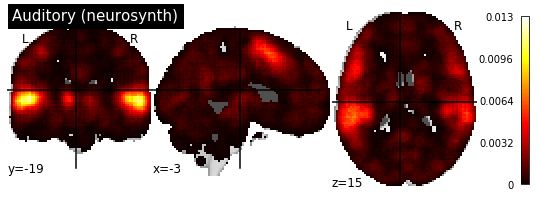

In [327]:
plotting.plot_stat_map(prob_img, title='Auditory (neurosynth)')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retv

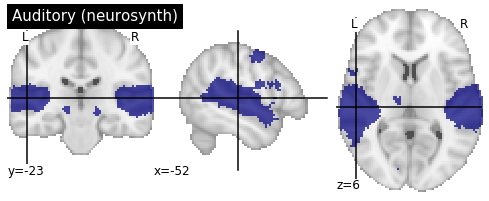

In [284]:
from neurolang.datalog.expressions import TranslateToLogic
from neurolang import expression_walker as ew
from neurolang.datalog.aggregation import DatalogWithAggregationMixin
from neurolang.datalog.chase import ChaseSemiNaive, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
from neurolang.datalog.aggregation import Chase
from neurolang.expressions import ExpressionBlock, Symbol, Constant
from neurolang.logic import Implication
from neurolang.frontend.neurosynth_utils import NeuroSynthHandler
from neurolang.datalog import DatalogProgram
from neurolang.expression_walker import ExpressionBasicEvaluator
from neurolang.datalog.aggregation import AggregationApplication
from neurolang.regions import Region, region_union as region_union_
import typing 

class DatalogTranslator(
    TranslateToLogic, ew.IdentityWalker, DatalogWithAggregationMixin
):
    pass

class Chase2(
    Chase, ChaseNaive, ChaseNamedRelationalAlgebraMixin, ChaseGeneral
):
    pass

class Datalog2(TranslateToLogic,
    DatalogWithAggregationMixin, DatalogProgram,
    ExpressionBasicEvaluator):
    pass

C_ = Constant
S_ = Symbol

y = S_('y')
z = S_('z')
over = S_('over')
neurosynth = S_('neurosynth')

from neurolang import frontend as fe
nl = fe.NeurolangDL()
@nl.add_symbol
def region_union(
    region_set: typing.AbstractSet[Region]
) -> Region:
    return region_union_(region_set)

region_union = nl.symbols.region_union.expression()
region_union.args = (z,)

agap = AggregationApplication(region_union.functor, (y,))

imps = tuple()
imps += (Implication(over(agap), neurosynth(C_('auditory'), y)),)
qB2 = ExpressionBlock(imps)
dt = DatalogTranslator()
qB2 = dt.walk(qB2)

q = 0.01
nshandler = NeuroSynthHandler()
neurosynth_data = nshandler.ns_region_set_from_term(
    'auditory',
    q=q
)

dl2 = Datalog2()
dl2.add_extensional_predicate_from_tuples(neurosynth, [('auditory', a) for a in neurosynth_data])
                     

eB22 = dt.walk(qB2)
dl2.walk(eB22)

dc = Chase2(dl2)
solution_instance = dc.build_chase_solution()
list(solution_instance.keys())

from nilearn import plotting

list_regions = list(solution_instance['over'].value.unwrapped_iter())
for region in list_regions:
    plotting.plot_roi(region[0].spatial_image(), title='Auditory (neurosynth)')